In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install flaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sys
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
from sklearn import metrics

from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from collections import Counter
from flaml import AutoML

import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [4]:
%cd '/content/drive/MyDrive/Genetic_info_breed/'

/content/drive/MyDrive/Genetic_info_breed


In [5]:
# reproducibility
def set_seed(seed_num):
  # tf.random.set_seed(seed_num)
  np.random.seed(seed_num)
  rn.seed(seed_num)
  os.environ['PYTHONHASHSEED']=str(seed_num)

seed_num = 42
set_seed(seed_num)
     

# **1. Explore dataset**

`train.csv`   
id : 개체 고유 ID     
father : 개체의 가계 고유 번호 (0 : Unknown)   
mother : 개체의 모계 고유 번호 (0 : Unknown)   
gender : 개체 성별 (0 : Unknown, 1 : female, 2 : male)   
trait : 개체 표현형 정보    
15개의 SNP 정보 : SNP_01 ~ SNP_15   
**class : 개체의 품종 (A,B,C)**   
   
`snp_info.csv`   
15개의 SNP 세부 정보   
name : SNP 명   
chrom : 염색체 정보   
cm : Genetic distance   
pos : 각 마커의 유전체상 위치 정보   

In [6]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
info = pd.read_csv('dataset/snp_info.csv')

In [ ]:
train_df.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C


In [ ]:
test_df.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,0,0,0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,0,0,0,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,0,0,0,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,0,0,0,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,0,0,0,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G


In [ ]:
info.head()

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.0546,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.1567,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.2892,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.8749,53826064
4,SNP_05,BovineHD0600017032,6,80.5015,61779512


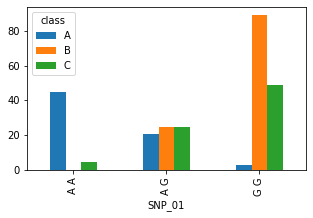

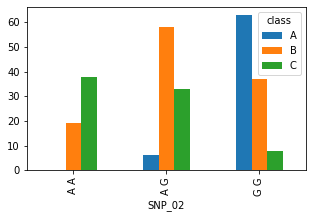

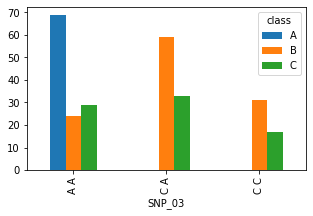

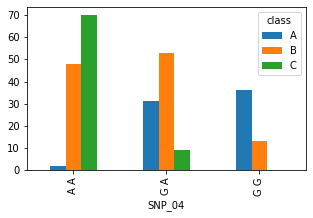

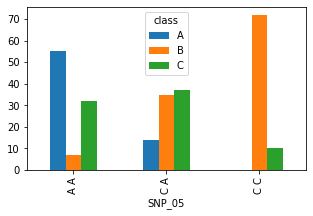

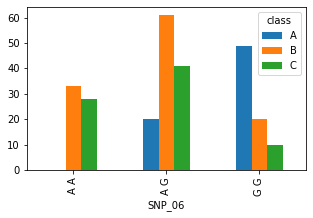

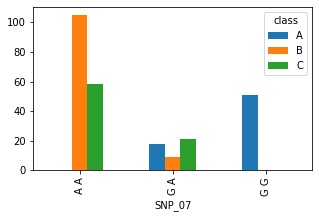

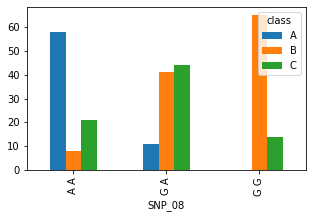

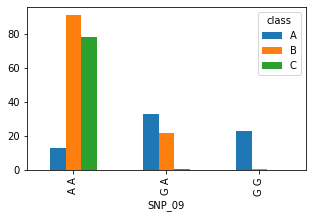

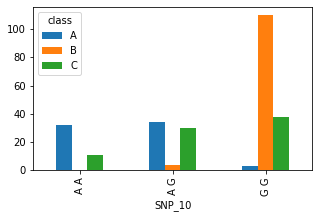

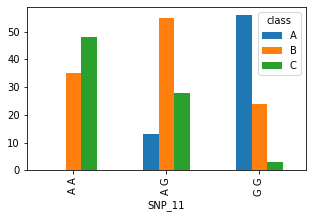

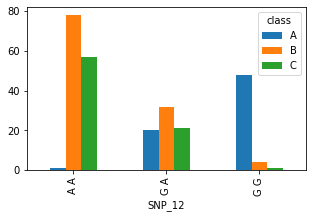

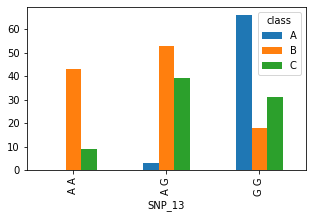

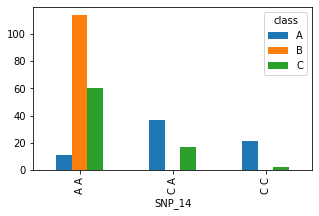

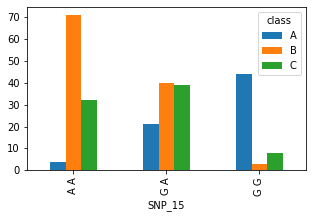

In [ ]:
for g in train_df.columns[train_df.columns.str.contains('SNP')].tolist():
    train_df.groupby(g)['class'].value_counts().unstack().plot.bar(figsize=(5,3));

In [7]:
drop_cols = ['id', 'father', 'mother', 'gender']

train_y = train_df['class']

train_df = train_df.drop(drop_cols, axis = 1)
test_df = test_df.drop(drop_cols, axis = 1)

In [8]:
train_df = train_df.drop('class', axis = 1)

In [9]:
# train = pd.get_dummies(train_df)
# test = pd.get_dummies(test_df)

# print(train.columns)
# print(test.columns)

In [10]:
train_x = train_df.copy()
test_x = test_df.copy()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(262, 16)
(262,)
(175, 16)


In [ ]:
MODEL_TIME_BUDGET = 60*100
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["lgbm"]

auto_lgbm = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_lgbm.fit(train_x, train_y, **params)

In [ ]:
MODEL_TIME_BUDGET = 60*100
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["xgboost"]

auto_xgb = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_xgb.fit(train_x, train_y, **params)

In [ ]:
MODEL_TIME_BUDGET = 60*100
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["rf"]

auto_rf = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_rf.fit(train_x, train_y, **params)

In [ ]:
MODEL_TIME_BUDGET = 60*100
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["extra_tree"]

auto_ext = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_ext.fit(train_x, train_y, **params)

In [ ]:
MODEL_TIME_BUDGET = 60*100
MODEL_METRIC = 'accuracy'
MODEL_TASK = "classification"
MODEL_LIST = ["catboost"]

auto_cat = AutoML()
params = {
    "time_budget": MODEL_TIME_BUDGET,  
    "metric": MODEL_METRIC,
    "estimator_list": MODEL_LIST, 
    "task": MODEL_TASK,
    "seed":seed_num,
}
auto_cat.fit(train_x, train_y, **params)

In [ ]:
# lightgbm = LGBMClassifier(colsample_bytree=0.6955603297767026,
#                learning_rate=0.8180702466547295, max_bin=127,
#                min_child_samples=30, n_estimators=24, num_leaves=5,
#                reg_alpha=0.3030044172834266, reg_lambda=3.472507521091055,
#                verbose=-1, seed = seed_num)

In [ ]:
# xgboost =  XGBClassifier(colsample_bylevel=0.574546786313928,
#               colsample_bytree=0.5411379114222521, grow_policy='lossguide',
#               learning_rate=1.0, max_depth=0, max_leaves=7,
#               min_child_weight=0.1391574848902682, n_estimators=26, n_jobs=-1,
#               objective='multi:softprob', reg_alpha=0.0009873650339164933,
#               reg_lambda=16.07188850565193, subsample=0.8674368836960172,
#               tree_method='hist', use_label_encoder=False, verbosity=0, seed = seed_num)

In [ ]:
# rf =  RandomForestClassifier(criterion='entropy', max_features=0.32018811892317617,
#                        max_leaf_nodes=17, n_estimators=14, n_jobs=-1,
#                        random_state=12032022)

In [ ]:
# ext =  ExtraTreesClassifier(criterion='entropy', max_features=0.3196243386495096,
#                      max_leaf_nodes=16, n_estimators=20, n_jobs=-1,
#                      random_state=12032022)

In [ ]:
lgb_p = auto_lgbm.predict(test_x)
xgb_p = auto_xgb.predict(test_x)
rf_p = auto_rf.predict(test_x)
ext_p = auto_ext.predict(test_x)
cat_p = auto_cat.predict(test_x)

In [ ]:
def mode(list):
    count = 0
    mode = 0;
    for x in list: 
        if list.count(x) > count:
            count = list.count(x)
            mode = x

    return mode

In [ ]:
prediction = []
for i in range(0, len(lgb_p)):
    prediction.append(mode([lgb_p[i], xgb_p[i], rf_p[i], ext_p[i], cat_p[i]]))
    # prediction.append(mode([lgb_p[i], xgb_p[i], cat_p[i]]))

print(prediction)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
sample_submission.head()

In [ ]:
sample_submission['class'] = prediction

In [ ]:
sample_submission.to_csv('flaml_long.csv',index = False)

In [ ]:
sample_submission.head()